In [1]:
import cv2 as cv
import json
import matplotlib.pyplot as plt

In [2]:
# Load images
image = cv.imread('data/Nordtank 2017/DJI_0602.jpg')
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

(2970, 5280, 3)

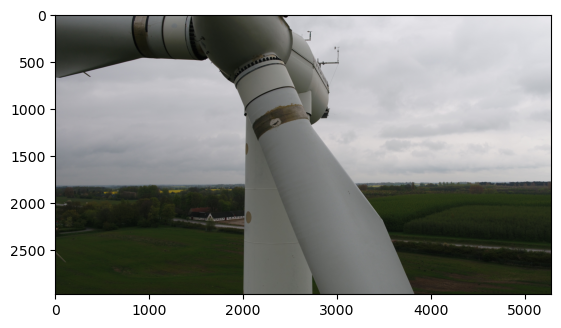

In [3]:
display(image.shape)
plt.imshow(image)

In [4]:
image_norm = image / 255.0
image_norm

array([[[0.43921569, 0.45490196, 0.46666667],
        [0.43529412, 0.45098039, 0.4627451 ],
        [0.43921569, 0.45490196, 0.46666667],
        ...,
        [0.90588235, 0.90980392, 0.9254902 ],
        [0.90588235, 0.90980392, 0.9254902 ],
        [0.90196078, 0.90588235, 0.92156863]],

       [[0.45490196, 0.47058824, 0.48235294],
        [0.43921569, 0.45490196, 0.46666667],
        [0.43137255, 0.44705882, 0.45882353],
        ...,
        [0.90588235, 0.90980392, 0.9254902 ],
        [0.90588235, 0.90980392, 0.9254902 ],
        [0.90588235, 0.90980392, 0.9254902 ]],

       [[0.44705882, 0.4627451 , 0.4745098 ],
        [0.43921569, 0.45490196, 0.46666667],
        [0.43137255, 0.44705882, 0.45882353],
        ...,
        [0.90588235, 0.90980392, 0.9254902 ],
        [0.90588235, 0.90980392, 0.9254902 ],
        [0.90588235, 0.90980392, 0.9254902 ]],

       ...,

       [[0.11764706, 0.14901961, 0.06666667],
        [0.12156863, 0.15294118, 0.07058824],
        [0.11764706, 0

In [5]:
# Read a JSON file
with open('data/Annotations/train.json') as f:
    trainJSON = json.load(f)

with open('data/Annotations/dev.json') as f:
    devJSON = json.load(f)

with open('data/Annotations/test.json') as f:
    testJSON = json.load(f)

In [6]:
classes = trainJSON['categories']
images_metadata = trainJSON['images']
annotations = trainJSON['annotations']

In [7]:
print('========= Classes =========')
display(classes)
print('========= Images metadata =========')
display(images_metadata)
print('========= Annotations =========')
display(annotations)

========= Classes =========


[{'id': 1, 'name': 'LE;ER', 'supercategory': None},
 {'id': 4, 'name': 'SF;PO', 'supercategory': None},
 {'id': 0, 'name': 'VG;MT', 'supercategory': None},
 {'id': 2, 'name': 'LR;DA', 'supercategory': None},
 {'id': 3, 'name': 'LE;CR', 'supercategory': None}]

========= Images metadata =========


[{'id': 0,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0058_1_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 1,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0013_0_3.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 2,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-images/',
  'file_name': 'DJI_0013_1_1.JPG',
  'path': None,
  'width': 1024,
  'height': 1024,
  'depth': 3},
 {'id': 3,
  'folder': '/content/drive/MyDrive/AVALON/DTU-S2-and-S3/DTU-S3/S3-HR-train70-test15-val15-split/HR-dataset-split/Data-preparation/train-data/1024-s/train-ima

========= Annotations =========


[{'image_id': 0,
  'id': 0,
  'segmented': None,
  'bbox': [383.996928, 424.001024, 99.00032, 90.000384],
  'area': 8910.0668161229,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 1,
  'difficult': None},
 {'image_id': 0,
  'id': 1,
  'segmented': None,
  'bbox': [616.001024, 20.00128, 45.999104, 47.000576],
  'area': 2161.9843834839,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 4,
  'difficult': None},
 {'image_id': 1,
  'id': 2,
  'segmented': None,
  'bbox': [212.99968, 588.000256, 43.000832, 31.000576],
  'area': 1333.0505604792,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 0,
  'difficult': None},
 {'image_id': 1,
  'id': 3,
  'segmented': None,
  'bbox': [575.001088, 555.000832, 43.000832, 31.000576],
  'area': 1333.0505604792,
  'segmentation': None,
  'iscrowd': 0,
  'pose': None,
  'truncated': None,
  'category_id': 0,
  'difficult':